In [0]:
import pandas as pd
import numpy as np
# !pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

#Read linked in csv and drop duplicates


In [0]:
df = pd.read_csv('/content/LinkedIn_datasource.csv',sep=',')
df.drop_duplicates(inplace=True)

In [0]:
print("Before dropping:",len(df.columns),"columns")
#drop columns with more than 60% of values missing
df_dropped = df.dropna(thresh = (len(df) * .4) , axis = 1)

print("List of columns dropped")
for col in df.columns.difference(df_dropped.columns):
    print(col)

df = df_dropped
df = df.join(email_col)
print("After dropping:",len(df.columns),"columns")

Before dropping: 130 columns
List of columns dropped
Address
Birthday
Connected at
Education 3
Education Degree 3
Education Description 1
Education Description 2
Education Description 3
Education End 3
Education FOS 3
Education Grade 1
Education Grade 2
Education Grade 3
Education Start 3
Email
Followers
Messenger 1
Messenger 1 type
Messenger 2
Messenger 2 type
Messenger 3
Messenger 3 type
Organization 6
Organization 7
Organization Description 5
Organization Description 6
Organization Description 7
Organization Domain 1
Organization Domain 2
Organization Domain 3
Organization Domain 4
Organization Domain 5
Organization Domain 6
Organization Domain 7
Organization End 6
Organization End 7
Organization LI ID 5
Organization LI ID 6
Organization LI ID 7
Organization LI URL 6
Organization LI URL 7
Organization Location 5
Organization Location 6
Organization Location 7
Organization Start 6
Organization Start 7
Organization Title 6
Organization Title 7
Organization WWW 1
Organization WWW 2
Org

# Determine Spending power

### Student status
Find out if the user is a student or not, by taking their latest education profile. If the the end date of education is before 2019, we assume they are not students, and everyone else will be marked as students.

In [0]:
#If a current student, we set their education end date to after 2019 (+4 years), for easier calculation
df['Education End 1'][df['Education End 1'] == "PRESENT"] = 2023 
#Assume if no values entered, they are not student
df['Education End 1'] = df['Education End 1'].fillna(0) 
#Sift out users who are not a student
df['Non_Student'] = (df['Education End 1'].astype(int) < 2019).astype(int)

df[['Education End 1','Non_Student']].head(10)

,Education End 1,Non_Student
0,2019,0
1,2017,1
2,2013,1
3,2011,1
4,2020,0
5,2010,1
6,2014,1
7,2021,0
8,2023,0
9,2016,1


[Text(0, 0.5, 'count'), Text(0.5, 0, 'Non student')]

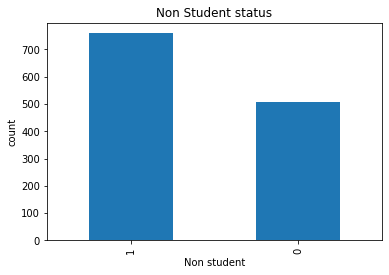

In [0]:
CountStatus = pd.value_counts(df['Non_Student'].values, sort=True)   
ax = CountStatus.plot.bar(title='Non Student status')
ax.set(xlabel="Non student", ylabel="count")

### Highest education status
Find out the highest education that the user has obtained. This will roughly gauge the potential of their career which translates to their rough remuneration. We use fuzzy matching to match the level of education using keywords such as university, polytechnic or junior college)

In [0]:
#visualize the distribution of schools
with pd.option_context('display.max_rows', 300):
    print(df['Education 1'].value_counts())

Singapore Management University                                                                    275
National University of Singapore                                                                   121
Nanyang Technological University                                                                   104
RMIT University                                                                                     49
Ngee Ann Polytechnic                                                                                34
Murdoch University                                                                                  28
Singapore Polytechnic                                                                               28
University of London                                                                                27
SIM Global Education                                                                                26
Nanyang Polytechnic                                                      

In [0]:
data = {'School':[4,3,2,1],
        'School1':['University','Polytechnic','Junior College','Below tertiary'],
        'School2':['College','High School','','Primary'],
        'School3':['SIM Global Education','','','Secondary']}

df_match_edu = pd.DataFrame(data)

#For every column, we have a list of categories of school for matching
#We set a minimum score for matching, if the matching score falls below 30, we set their education category to 1 by default.
df['eduscore'] = 50
df['Education_category'] = 1

for column in df_match_edu.columns[1:]:
    match = list(map(lambda x: process.extractOne(x, df_match_edu[column], scorer=fuzz.token_set_ratio, processor=lambda x: x),df['Education 1'].astype(str).str.strip()))
    match = pd.DataFrame(match)
    match.columns = ['match', 'score', 'index']
    df['eduscore1'] = list(match['score'])
    df['edu_category'] = list(df_match_edu.loc[match['index']].School)

    df['Education_category'] = np.where(df['eduscore']>= df['eduscore1'], df['Education_category'], df['edu_category'])
    df['eduscore'] = df[['eduscore', 'eduscore1']].max(axis=1)
    
df[['Education 1','Education_category']].head(10)

,Education 1,Education_category
0,Singapore Management University,4
1,Singapore Management University,4
2,Northumbria University,4
3,Nanyang Technological University,4
4,SIM Global Education,4
5,SIM Global Education,4
6,Murdoch University,4
7,Singapore Management University,4
8,University of ireland,4
9,Singapore Management University,4


In [0]:
df[['Education 1','Education_category','eduscore']][df['Education_category']==1].tail(10)

,Education 1,Education_category,eduscore
1237,"CFTE - Centre for Finance, Technology and Entr...",1,50
1239,B.E. (Electronics),1,50
1241,INSEAD,1,50
1243,Pratt Institute,1,50
1244,Vellore Institute of Technology,1,50
1257,CTFE,1,50
1262,Chartered Accountants Australia and New Zealand,1,50
1267,Singapore Institute of Management,1,50
1268,Uni of Bradford,1,50
1269,"APM Group, UK",1,50


[Text(0, 0.5, 'count'), Text(0.5, 0, 'Education category')]

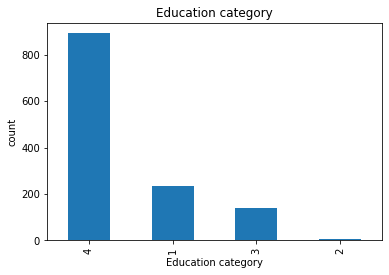

In [0]:
CountStatus = pd.value_counts(df['Education_category'].values, sort=True)   
ax = CountStatus.plot.bar(title='Education category')
ax.set(xlabel="Education category", ylabel="count")

### Years of experience
Find out the number of years of experience by subtracting present time or last worked year, by the year the user first worked in, i.e. their first job.
We are able to gauge the level of their spending power by looking at the years of experience in the workforce.

In [0]:
#Initiate new columns to store first and last worked year
df['Last_worked_year'] = np.NaN
df['First_worked_year'] = np.NaN

#If currently working in a job, we set their last worked year as 2019 (current)
df['Organization End 1'][df['Organization End 1'] == "PRESENT"] = "2019"
df['Organization End 1'] = df['Organization End 1'].str.extract('(\d+)')
df['Last_worked_year'] = df['Organization End 1']

#Keep only the numerical years
cols = ['Organization Start 1','Organization Start 2','Organization Start 3','Organization Start 4','Organization Start 5']
for col in cols:
    df[col] = df[col].str.extract('(\d+)')

#Take the first worked year of their first job, i.e. starting year
for col in cols:
    df['First_worked_year'][df[col].notnull()] = df[col][df[col].notnull()]

#Get working years by subtracting the last worked year by first worked year
df['Last_worked_year'] = df['Last_worked_year'].fillna(0).str.extract('(\d+)')
df['First_worked_year'] = df['First_worked_year'].fillna(0).str.extract('(\d+)')
df['Working_years'] = df['Last_worked_year'].astype(float) - df['First_worked_year'].astype(float)

df[['Organization End 1','Organization Start 1','Organization Start 2','Organization Start 3','Organization Start 4','Organization Start 5','Working_years']].head(10)

,Organization End 1,Organization Start 1,Organization Start 2,Organization Start 3,Organization Start 4,Organization Start 5,Working_years
0,2019,2019,2018,2018,2017,2017,2.0
1,2019,2017,2017,2016,2015,2014,5.0
2,2019,2016,2018,2016,2015,2014,5.0
3,2019,2019,2018,2013,2011,2010,9.0
4,2019,2019,2018,2017,2017,2017,2.0
5,2019,2018,2016,2015,2014,2012,7.0
6,2019,2017,2015,2014,2012,2010,9.0
7,2019,2019,2015,2014,NaN,NaN,5.0
8,2019,2016,2018,NaN,NaN,NaN,1.0
9,2019,2018,2014,2012,2014,NaN,5.0


[Text(0, 0.5, 'Working years'), Text(0.5, 0, 'count')]

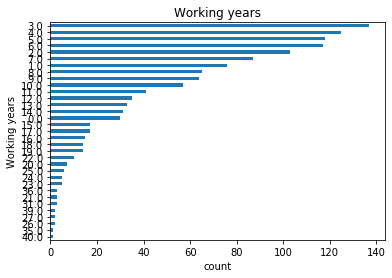

In [0]:
CountStatus = pd.value_counts(df['Working_years'].values, sort=True)   
ax = CountStatus.sort_values().plot.barh(title='Working years')
ax.set(ylabel="Working years", xlabel="count")

[Text(0, 0.5, 'Working years'), Text(0.5, 0, 'count')]

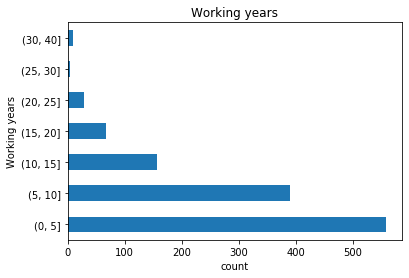

In [0]:
bins = [0, 5, 10, 15, 20, 25, 30,40]
s = pd.cut(df['Working_years'], bins=bins).value_counts()
s = df.groupby(pd.cut(df['Working_years'], bins=bins)).size()
ax = s.plot.barh(title='Working years')
ax.set(ylabel="Working years", xlabel="count")

### Corporate position
Find the job title and standardize it to 3 levels: Director, manager or associate level. A higher corporate position will likely to translate to higher spending power as well.  

We perform fuzzy matching on their job titles to match it to a score of 3, with 3 being the highest ranking in the corporate world. 

In [0]:
data = {'Title':[3,2,1],
        'Title1':['Director','Manager','Associate'],
        'Title2':['Partner','Supervisor','Executive'],
        'Title3':['Founder','Lead','Advisor']}

df_match_title = pd.DataFrame(data)

#For every column, we have a list of categories of job title for matching. We set the minimum matching score at 30. 
#If the match score does not exceed 30, we just assume a job title category of 1.
df['titlescore'] = 40 
df['Title_category'] = 1

for column in df_match_title.columns[1:]:
    match = list(map(lambda x: process.extractOne(x, df_match_title[column], scorer=fuzz.token_set_ratio, processor=lambda x: x),df['Title'].astype(str).str.strip()))
    match = pd.DataFrame(match)
    match.columns = ['match', 'score', 'index']
    df['titlescore1'] = list(match['score'])
    df['title_category'] = list(df_match_title.loc[match['index']].Title)
    
    df['Title_category'] = np.where(df['titlescore']>= df['titlescore1'], df['Title_category'], df['title_category'])
    df['titlescore'] = df[['titlescore', 'titlescore1']].max(axis=1)
    
df[['Title','Title_category']].head(10)

,Title,Title_category
0,Group Governance and Operational Risk Manageme...,1
1,Estate Analyst at Bequest Pte Ltd,1
2,Impacting Life One at a Time,1
3,Manager at Prudential Assurance Company Singapore,2
4,Senior Financial Planner at GREAT EASTERN,1
5,"Head, Bancassurance Business Development at GR...",1
6,"Assistant Manager, Talent Management at Accoun...",2
7,Intern at Group Customer Analytics and CRM dep...,1
8,I'm a simple girl.,1
9,Wealth Management Specialist at Advisors Allia...,1


In [0]:
df[['Title','Title_category','titlescore']][df['Title_category']==3].tail(10)

,Title,Title_category,titlescore
1082,"Coach , Trainer, Speaker | Founder of Alvin Ch...",3,100
1114,Financial Doctor,3,42
1124,Talent & Performance Management Partner,3,100
1135,"Financial service director, Prudential Assurance",3,100
1151,Group Director at PIAS (Professional Investmen...,3,100
1172,Founder at Ascension Consultancy,3,100
1184,Founder | Assets Prestige Alliance - Jaden Wan...,3,100
1199,Learning Partner at Prudential Assurance Compa...,3,100
1201,Senior Financial Services Director & Founder a...,3,100
1250,Financial advisor - Value add to finance portf...,3,100


[Text(0, 0.5, 'Corporate position'), Text(0.5, 0, 'count')]

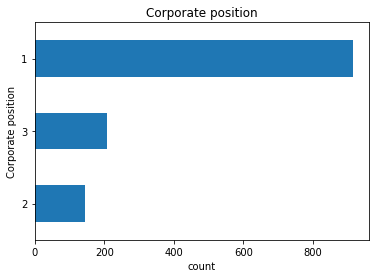

In [0]:
CountStatus = pd.value_counts(df['Title_category'].values, sort=True)   
ax = CountStatus.sort_values().plot.barh(title='Corporate position')
ax.set(ylabel="Corporate position", xlabel="count")

# Leasing Propensity

### Profile matching
We also did a similarity score matching of the profiles, to see if any predefined keywords are being mentioned. For instance, if their profiles mention 'meeting' and 'connecting' more often, then we can infer that they are likely to need a vehicle.

In [0]:
#Defining our keyword list
keywords = ['meeting','clients','connecting','plan','insurance','travel','advisor']

#load the pre-trained vector (trained on wikipedia articles)
model = KeyedVectors.load_word2vec_format('/content/glove.6B.50d.txt', binary=False)

In [0]:
#If no summary is written, replace by empty string
df['Summary'].fillna("",inplace=True)

df['Profile_similarity'] = np.NaN

prof_sim = []
#Find the average similarity across all words in a sentence
for sent in df['Summary']:
    average_similarity = 0
    word_count = 1
    avg_sim = 0
    #Get the best similarity score for every word in the sentence and in keyword list.
    for word in sent:
        max_sim = 0
        word_count += 1
        for kword in keywords:
            if word in model.vocab and kword in model.vocab:
                if model.similarity(word,kword) > max_sim:
                    max_sim = model.similarity(word,kword)
        
        avg_sim += max_sim
    
    avg_sim /= word_count
    prof_sim.append(avg_sim)    

df['Profile_similarity'] =  pd.Series(prof_sim)

In [0]:
df['Profile_similarity'][df['Summary'] == ""] = 0
df[['Summary','Profile_similarity']].head(10)

,Summary,Profile_similarity
0,If there is one element of myself that I have ...,0.320495
1,"Known to be a great team player, Amber has vol...",0.339094
2,"In life, we are facing with a lot of uncertain...",0.333927
3,,0.000000
4,I am passionate to make sure that you and your...,0.322602
5,I shall not start off by throwing a bunch of c...,0.299216
6,,0.000000
7,I am an undergraduate student at Singapore Man...,0.328073
8,Seeking Good coffee talk.,0.318164
9,Tung (Steve) is a sophomore student in Singapo...,0.335043


# Multiply relevant columns by their weights (similarity scores)
Due to the fuzzy matching process, we assign a category to each profile. However, not all profiles will have a full match and the degree of the match is dependent on the similarity score (in %). Hence, we multiply it to factor the confidence level of the similarity of the category is to the true category. For example, if the score is a 100, it means we are fully confident that the assigned category is true and hence assign a higher score to the profile.

Highest education status 

In [0]:
df['Education_category'] = df['Education_category'] * df['eduscore']
df[['Education 1','Education_category','eduscore']].sort_values('Education_category',ascending=False).head(10)

,Education 1,Education_category,eduscore
0,Singapore Management University,400,100
747,Monash University,400,100
729,University of Winchester,400,100
730,National University of Singapore,400,100
731,University College Dublin,400,100
732,RMIT University,400,100
734,RMIT University,400,100
735,National University of Singapore,400,100
737,The University of Queensland,400,100
738,National University of Singapore,400,100


Corporate position

In [0]:
df['Title_category_weighted'] = df['Title_category'] * df['titlescore']
df[['Title','Title_category_weighted','titlescore']].sort_values('Title_category_weighted',ascending=False).head(10)

,Title,Title_category_weighted,titlescore
793,Marketing Director at ERA Real Estate,300,100
608,Financial Services Director,300,100
301,Associate District Director at PropNex Realty ...,300,100
241,Founder at Amazon Lifestyle Academy ⭐ Transfor...,300,100
866,Senior Marketing Director at ERA Real Estate,300,100
266,Associate Group Director at PropNex Realty Pte...,300,100
867,Group Division Director at ERA Real Estate,300,100
303,Senior Associate Marketing Director at PropNe...,300,100
1184,Founder | Assets Prestige Alliance - Jaden Wan...,300,100
872,Senior Marketing Director at ERA Real Estate,300,100


# Saving the dataframe
Sift out only the columns that we need and scale the scores to between 0 and 1.

In [0]:
df_final = df[['id','Full name','Profile url','Location','Title','Title_category','Organization 1','Working_years','Non_Student','Education_category','Industry','Industry_CustomerFacing','Profile_similarity']]

mm_scaler = preprocessing.MinMaxScaler()
df_final['Working_years_scaled'] = df['Working_years']
df_final['Title_category_scaled'] = df['Title_category_weighted']

df_final[['Title_category_scaled','Working_years_scaled','Non_Student','Education_category','Profile_similarity']] = mm_scaler.fit_transform(df_final[['Title_category_scaled','Working_years_scaled','Non_Student','Education_category','Profile_similarity']])
df_final.head()

,id,Full name,Profile url,Location,Title,Title_category,Organization 1,Working_years,Non_Student,Education_category,Industry,Industry_CustomerFacing,Profile_similarity,Working_years_scaled,Title_category_scaled
0,weienthong,Wei En THONG,https://www.linkedin.com/in/weienthong/,Singapore,Group Governance and Operational Risk Manageme...,1,GREAT EASTERN,2.0,0.0,1.0,Financial Services,1,0.873769,0.050,0.000000
1,amberpoo,"Poo Men Shuen, Amber",https://www.linkedin.com/in/amberpoo/,Singapore,Estate Analyst at Bequest Pte Ltd,1,GREAT EASTERN,5.0,1.0,1.0,Financial Services,1,0.924473,0.125,0.000000
2,jerome-lim,Jerome Lim,https://www.linkedin.com/in/jerome-lim/,Singapore,Impacting Life One at a Time,1,GREAT EASTERN,5.0,1.0,1.0,Financial Services,1,0.910386,0.125,0.000000
3,amanda-lim-30813254,Amanda Lim,https://www.linkedin.com/in/amanda-lim-30813254/,Singapore,Manager at Prudential Assurance Company Singapore,2,Prudential Assurance Company Singapore,9.0,1.0,1.0,Financial Services,1,0.000000,0.225,0.615385
4,ijeremytang,Jeremy Tang,https://www.linkedin.com/in/ijeremytang/,Singapore,Senior Financial Planner at GREAT EASTERN,1,GREAT EASTERN,2.0,0.0,1.0,Financial Services,1,0.879511,0.050,0.000000


In [0]:
df_final.to_csv('Linkedin_processed_withscore.csv')

# Determining their spending power score and leasing propensity score.
The scores of each measure in spending power and leasing propensity is summed up normalized to a range of 0 to 2 per profile, with 2 indicating the highest score (most valuable customer)

In [0]:
df = pd.read_csv('/content/Linkedin_processed_withscore.csv')

In [0]:
df['Spending Power'] = df['Title_category_scaled'] + df['Non_Student'] + df['Education_category'] +df['Working_years_scaled']
df['Leasing Propensity'] = df['Profile_similarity'] 

mm_scaler = preprocessing.MinMaxScaler()
df[['Spending Power','Leasing Propensity']] = mm_scaler.fit_transform(df[['Spending Power','Leasing Propensity']])
df.head()

,Unnamed: 0,Unnamed: 0.1,id,Full name,Profile url,Location,Title,Title_category,Organization 1,Working_years,Non_Student,Education_category,Industry,Profile_similarity,Working_years_scaled,Title_category_scaled,Spending Power,Leasing Propensity,Final Score
0,0,0,weienthong,Wei En THONG,https://www.linkedin.com/in/weienthong/,Singapore,Group Governance and Operational Risk Manageme...,1,GREAT EASTERN,2.0,0.0,1.0,Financial Services,0.873769,0.050,0.000000,0.269231,0.873769,1.206115
1,1,1,amberpoo,"Poo Men Shuen, Amber",https://www.linkedin.com/in/amberpoo/,Singapore,Estate Analyst at Bequest Pte Ltd,1,GREAT EASTERN,5.0,1.0,1.0,Financial Services,0.924473,0.125,0.000000,0.544872,0.924473,1.507108
2,2,2,jerome-lim,Jerome Lim,https://www.linkedin.com/in/jerome-lim/,Singapore,Impacting Life One at a Time,1,GREAT EASTERN,5.0,1.0,1.0,Financial Services,0.910386,0.125,0.000000,0.544872,0.910386,1.500065
3,3,3,amanda-lim-30813254,Amanda Lim,https://www.linkedin.com/in/amanda-lim-30813254/,Singapore,Manager at Prudential Assurance Company Singapore,2,Prudential Assurance Company Singapore,9.0,1.0,1.0,Financial Services,0.000000,0.225,0.615385,0.728304,0.000000,1.228304
4,4,4,ijeremytang,Jeremy Tang,https://www.linkedin.com/in/ijeremytang/,Singapore,Senior Financial Planner at GREAT EASTERN,1,GREAT EASTERN,2.0,0.0,1.0,Financial Services,0.879511,0.050,0.000000,0.269231,0.879511,1.208986


In [0]:
df.to_csv('Linkedin_processed_withscore.csv')

# Analysis of final scores

In [0]:
df['Final Score'] = df['Spending Power'] + df['Leasing Propensity']

[Text(0, 0.5, 'count'), Text(0.5, 0, 'Final Score')]

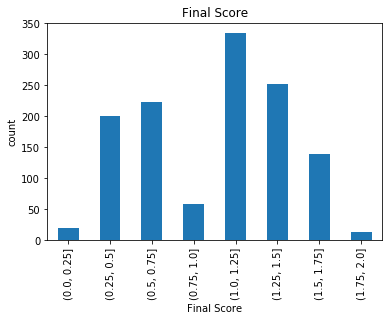

In [0]:
bins = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5,1.75,2]
s = pd.cut(df['Final Score'], bins=bins).value_counts()
s = df.groupby(pd.cut(df['Final Score'], bins=bins)).size()
ax = s.plot.bar(title='Final Score')
ax.set(xlabel="Final Score", ylabel="count")

Take the top 10%, roughly the top 153 profiles

In [0]:
df_final = df[df['Final Score']>= 1.5]
df_final

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,Full name,Profile url,Location,Title,Title_category,Organization 1,Working_years,Non_Student,Education_category,Industry,Profile_similarity,Working_years_scaled,Title_category_scaled,Spending Power,Leasing Propensity,Final Score
24,24,24,24,christophertan-aia,Christopher Tan,https://www.linkedin.com/in/christophertan-aia/,Singapore,Director Financial Services at AIA Singapore (...,3,AIA,24.0,1.0,0.428571,Financial Services,0.858319,0.600,1.000000,0.776557,0.858319,1.634875
26,26,26,26,john-chua-chfc-clu-b5ab9a,"John Chua ChFC, CLU",https://www.linkedin.com/in/john-chua-chfc-clu...,Singapore,Making a Difference...,1,RTP Organisation,35.0,1.0,0.714286,Financial Services,0.886153,0.875,0.000000,0.663919,0.886153,1.550073
29,29,29,29,jackie-wee-2bb31650,Jackie Wee,https://www.linkedin.com/in/jackie-wee-2bb31650/,Singapore,Financial Planner,1,AIA,39.0,1.0,1.000000,Financial Services,0.910752,0.975,0.000000,0.762821,0.910752,1.673572
37,37,37,37,sherontan,Sheron Tan,https://www.linkedin.com/in/sherontan/,Singapore,Personal Wealth Manager at AIA,2,AIA,9.0,1.0,1.000000,Financial Services,0.868231,0.225,0.615385,0.728304,0.868231,1.596534
38,38,38,38,kelvin-akw,Ang Kia Wee (Kelvin),https://www.linkedin.com/in/kelvin-akw/,Singapore,Risk Management Specialist,2,AIA Singapore,9.0,1.0,1.000000,Financial Services,0.910157,0.225,0.169231,0.613905,0.910157,1.524062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,1236,1236,1242,hilda777,Hilda Huang,https://www.linkedin.com/in/hilda777/,Singapore,Competency Development and Assurance Executive...,1,Prudential Assurance Company Singapore,9.0,1.0,1.000000,Financial Services,0.875546,0.225,0.230769,0.629684,0.875546,1.505231
1239,1239,1239,1245,dr-jasneet-kalra-801b731b,Dr. Jasneet Kalra,https://www.linkedin.com/in/dr-jasneet-kalra-8...,Singapore,Claims Manager,2,Income,10.0,1.0,1.000000,Financial Services,0.944790,0.250,0.615385,0.734714,0.944790,1.679504
1243,1243,1243,1249,tze-hong-goh-614314165,Tze Hong Goh,https://www.linkedin.com/in/tze-hong-goh-61431...,Singapore,Senior Manager at Prudential Assurance Company...,2,Prudential Assurance Company Singapore,11.0,1.0,1.000000,Financial Services,0.930597,0.275,0.615385,0.741124,0.930597,1.671721
1245,1245,1245,1251,cindy-gwee-01442b48,Cindy Gwee,https://www.linkedin.com/in/cindy-gwee-01442b48/,Singapore,Actuarial Senior Executive at Prudential Assur...,1,Prudential Assurance Company Singapore,9.0,1.0,1.000000,Financial Services,0.949442,0.225,0.230769,0.629684,0.949442,1.579127


## Plot the top 5 organizations

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Organization')]

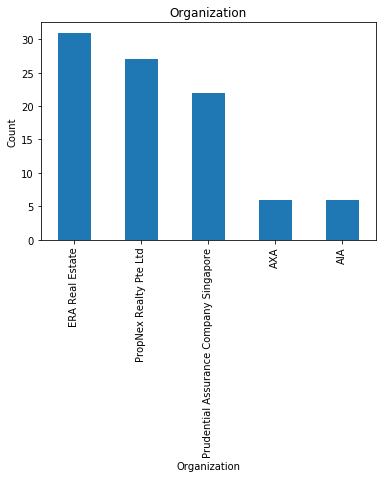

In [0]:
CountStatus = pd.value_counts(df_final['Organization 1'].values)   
ax = CountStatus.sort_values(ascending=False)[:5].plot.bar(title='Organization')
ax.set(ylabel="Count", xlabel="Organization")

# Working years distribution

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Working years')]

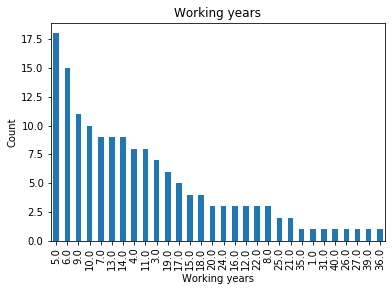

In [0]:
CountStatus = pd.value_counts(df_final['Working_years'].values)   
ax = CountStatus.sort_values(ascending=False).plot.bar(title='Working years')
ax.set(ylabel="Count", xlabel="Working years")

[Text(0, 0.5, 'count'), Text(0.5, 0, 'Working years')]

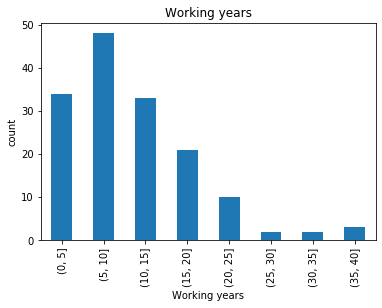

In [0]:
bins = [0, 5, 10, 15, 20, 25, 30,35,40]
s = pd.cut(df_final['Working_years'], bins=bins).value_counts()
s = df_final.groupby(pd.cut(df_final['Working_years'], bins=bins)).size()
ax = s.plot.bar(title='Working years')
ax.set(xlabel="Working years", ylabel="count")

# Title category distribution

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Title_category')]

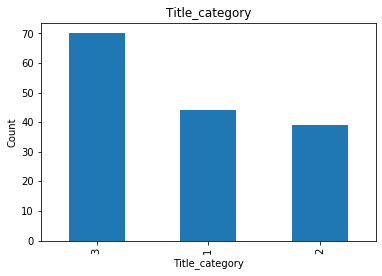

In [0]:
CountStatus = pd.value_counts(df_final['Title_category'].values)   
ax = CountStatus.sort_values(ascending=False)[:5].plot.bar(title='Title_category')
ax.set(ylabel="Count", xlabel="Title_category")